# Info
- paper
    - title: Adversarially Regularized Autoencoders
    - link: https://arxiv.org/pdf/1706.04223.pdf
- reference code
    - OFFICIAL: https://github.com/jakezhaojb/ARAE

# 결과는?
- 좋지 않았다...
- 일단 학습이 불안정해서 clipping하고 lr 조정하는 데에 고생했고, 고생했음에도 별로 성과는 없었음.
- 문장 생성이 잘 안 돼서 학습을 '전체 문장 예측'이 아니라 '이전 문장 --> 다음 단어' 예측으로 바꿨는데도 별로 소용은 없었음.
- mode collapse가 있는 느낌이라서 피해보려고 시도했지만 실패함.

- 끝!

# Summary

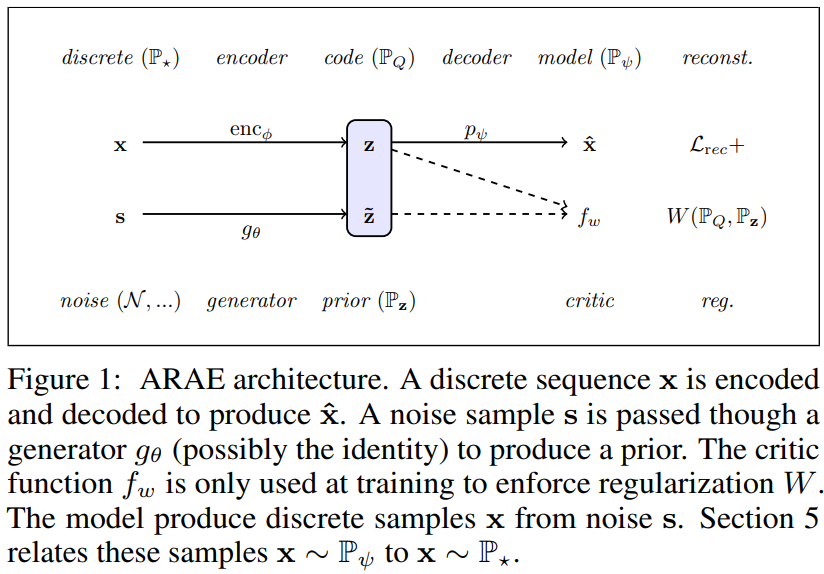
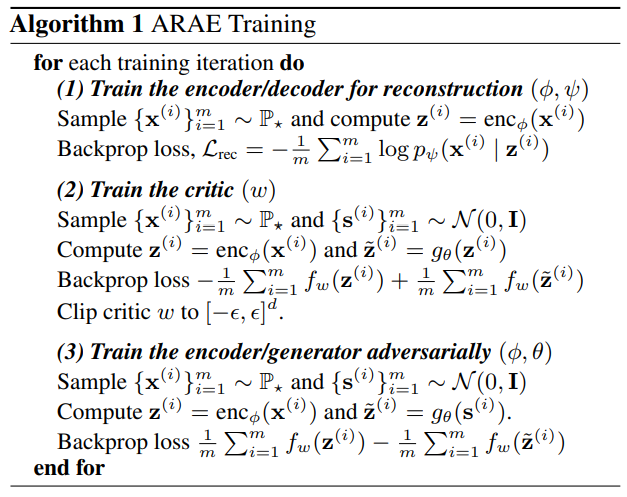
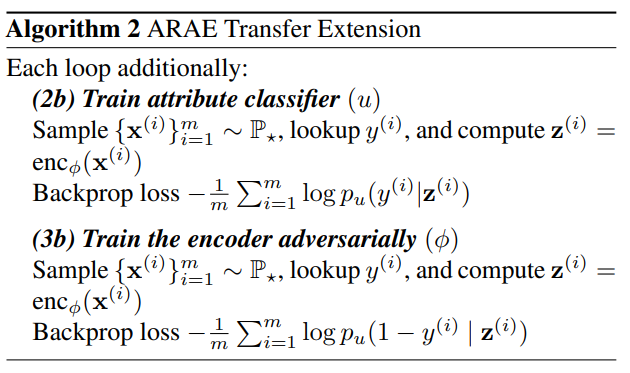
***
- Autoencoder
    - Text $x$ is fed into the RNN encoder.
    - The encoder produces latent variable $z$.
    - The RNN decoder reconstructs $\hat{x}$ from $z$.
        - The decoder input is an embedding concatenated with the last hidden state of the encoder.
        - The decoder has single layer.
    - Reconstruction loss: $L_{rec}(x, \hat{x})$
***
- Adversarial net for text generation
    - $z$ & $\tilde{z} \sim Z$ is obtained.
        - Text $x$ is fed into the encoder --> $z$ obtained.
        - Noise $s \sim N(0,I)$ is fed into the generator --> $\tilde{z}$ obtained.
            - The generator is an MLP.
            - Why the generator used on the prior instead of using the prior directly? --> the authors empirically found directly using the prior is unstable.
    - $z$ & $\tilde{z}$ are fed into critic function $f_w : Z \to \mathbb{R}$ --> $L_{adv} = \mathbb{E}[f_w(z)] - \mathbb{E}[f_w(\tilde{z})]$
        - $f_w$ is an MLP.
    - Critic training
        - Maximize the loss with weight clipping.
    - Encoder & generator training
        - Minimize the loss.
***
- Adversarial net for NOT encoding attributes
>If we want the machine capable of switching attribute (e.g., sentiment), the prior should encode all the information except about the attribute.
- 
    - Attribute classifier, $f_u$ <-- an MLP
    - Label $y$
    - Text $x$ is fed into the encoder --> $z$
    - Train attribute classifier $f_u$
        - The loss for $f_u(z)$ --predict--> $y$ is minimized by $f_u$.
    - Train the encoder
        - The loss for $f_u(z)$ --predict--> $1-y$ is minimized by the encoder.
***
- 추가 사항
    - decoder를 레이블 개수에 맞춰서 쓴다고 함. 예컨대, 레이블이 [0, 1] 이면 0인 텍스트만 전담하는 decoder_0, 1인 텍스트만 전담하는 decoder_1을 둠. 그리고 style transfer할 때에는 반대 decoder 사용. 예컨대 0 --> 1 style transfer이면, decoder_1을 사용해서 decoding 하라는 의미.

# Environment
- Windows 10
- pytorch 1.10.2
- GPU: RTX 3060 laptop (6 Gb)
    - required memory: no more than 5.9 Gb

# Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"pytorch_version :: {torch.__version__}")

pytorch_version :: 1.10.2


# Data

In [3]:
### Download the datasets // Thank you Naver!
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [4]:
import pandas as pd

trainset = pd.read_csv("ratings_train.txt", sep="\t")
testset = pd.read_csv("ratings_test.txt", sep="\t")

trainset = trainset[:60_000]
testset = testset[:10_000]

testset.tail(3)

,id,document,label
9997,8014316,"공항 셔틀버스 출입로는 cctv 다 있고 등록제인데, 안들킨게 비현실적",0
9998,10185879,뜬금없는 좀비의 출현... 개연성 없는 스토리... 좀비 영화의 바이블이라기에는 개...,0
9999,9630510,개노잼1111222,0


In [5]:
trainset_0 = trainset[trainset["label"]==0]
trainset_1 = trainset[trainset["label"]==1]
testset_0 = testset[testset["label"]==0]
testset_1 = testset[testset["label"]==1]

print(len(trainset_0))
print(len(trainset_1))
print(len(testset_0))
print(len(testset_1))

30046
29954
4939
5061


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-large")
tokenizer.vocab_size

30000

In [11]:
sample_text = """
인간이 이렇게도 슬픈데, 주여, 바다가 너무나 푸릅니다.
"""
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=30,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    return_tensors="pt",
    truncation=True,
)
print(tokens, "\n")
print(tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]))

{'input_ids': tensor([[    2,  8836,  8151,  4029, 18551,  4092,    15,  2627,  4327,    15,
         12965,  4009, 11318,  3314, 14725,    17,     3,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])} 

['[CLS]', '인간이', '이렇게', '##도', '슬픈', '##데', ',', '주', '##여', ',', '바다', '##가', '너무나', '푸', '##릅니다', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [8]:
PAD = 0; UNK = 1; CLS = 2; SEP = 3;

In [9]:
from torch.utils.data import Dataset

class NSMCDataset(Dataset):
    def __init__(self, data, seq_len, tokenizer=tokenizer):
        super().__init__()
        self.data = data
        self.seq_len = seq_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ## Get word IDs.
        text = self.data["document"].iloc[idx]
        text = str(text)
        tokens = self.tokenizer.encode_plus(
            text,
            max_length=self.seq_len,
            padding="max_length",
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=False,
            return_tensors="pt",
            truncation=True,
        )
        word_ids = tokens["input_ids"][0]
        ## Get labels
        label = self.data["label"].iloc[idx] # int
        label = torch.tensor([label], dtype=torch.float)
        ## Return
        return word_ids, label

In [10]:
from torch.utils.data import DataLoader

SEQ_LEN = 30

train_ds = NSMCDataset(data=trainset, seq_len=SEQ_LEN)
train_ds_0 = NSMCDataset(data=trainset_0, seq_len=SEQ_LEN)
train_ds_1 = NSMCDataset(data=trainset_1, seq_len=SEQ_LEN)

test_ds = NSMCDataset(data=testset, seq_len=SEQ_LEN)
test_ds_0 = NSMCDataset(data=testset_0, seq_len=SEQ_LEN)
test_ds_1 = NSMCDataset(data=testset_1, seq_len=SEQ_LEN)

BATCH_SIZE = 32

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
train_dl_0 = DataLoader(train_ds_0, batch_size=BATCH_SIZE, shuffle=True)
train_dl_1 = DataLoader(train_ds_1, batch_size=BATCH_SIZE, shuffle=True)

test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
test_dl_0 = DataLoader(test_ds_0, batch_size=BATCH_SIZE)
test_dl_1 = DataLoader(test_ds_1, batch_size=BATCH_SIZE)

In [10]:
X, y = next(iter(test_dl_0))
print(X.shape)
print(y.shape)

torch.Size([32, 30])
torch.Size([32, 1])


# Device

In [11]:
#device = "cuda:0" if torch.cuda.is_available() else "cpu" # Set the GPU number if needed.
device = "cpu"
device

'cpu'

# Modules

In [12]:
class RNN_Encoder(nn.Module):
    """ LSTM encoder with Gaussian noise """
    def __init__(
        self,
        word_vec_size=200,
        num_layers=1,
        hidden_size=300,
        bidirectional=False,
        lstm_dropout=0.1,
        emb_dropout=0.1,
        noise=0.2,
    ):
        super().__init__()
        ## Hyperparameters
        self.word_vec_size = word_vec_size
        self.num_layers = num_layers
        self.hidden_siz = hidden_size
        self.bidirectional = bidirectional
        self.noise = noise
        ## Factors
        self.vocab_size = tokenizer.vocab_size
        ## Layers
        self.word_id_to_emb = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=word_vec_size,
            padding_idx=PAD,
            #max_norm=True,
            #norm_type=2, # <-- 2 by default
        )
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.rnn = nn.LSTM(
            input_size=word_vec_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_dropout,
        )
        

    def forward(self, word_id, noise:bool): # The noise is only used for autoencoder training.
        ## Word IDs to embedding
        emb = self.word_id_to_emb(word_id)
        emb = self.emb_dropout(emb)
        ## RNN
        output, (hidden, cell) = self.rnn(emb) # The initial state is set by zeros by default.
        ## The hidden state of the last layer
        hidden = hidden[-1]
        ## L2 normalization
        hidden = F.normalize(hidden, p=2.0, dim=1)
        ## Add Gaussian noise.
        if noise==True:
            gaussian_noise = torch.normal(mean=torch.zeros(hidden.size()), std=self.noise).to(device)
            hidden += gaussian_noise
        
        return hidden # [batch, hidden_size]

In [13]:
class RNN_DualDecoder(nn.Module):
    """ Two LSTM Decoders with separate weights """
    def __init__(
        self,
        word_vec_size=200,
        num_layers=1,
        hidden_size=300,
        bidirectional=False,
        lstm_dropout=0.1,
        emb_dropout=0.1,
        noise=0.2,
    ):
        super().__init__()
        ## Hyperparameters
        self.word_vec_size = word_vec_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        ## Factors
        self.vocab_size = tokenizer.vocab_size
        self.hidden_factor = num_layers * (2 if bidirectional else 1)
        ## Layers
        self.word_id_to_emb_0 = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=word_vec_size,
            padding_idx=PAD,
            #max_norm=True,
            #norm_type=2, # <-- 2 by default
        )
        self.word_id_to_emb_1 = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=word_vec_size,
            padding_idx=PAD,
            #max_norm=True,
            #norm_type=2, # <-- 2 by default
        )
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.rnn_0 = nn.LSTM(
            input_size=word_vec_size + hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_dropout,
        )
        self.rnn_1 = nn.LSTM(
            input_size=word_vec_size + hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_dropout,
        )
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size*5, self.vocab_size),
        )
    
    
    def forward(self, word_id, which_decoder, hidden_from_encoder):
        ## Word IDs to embedding
        if which_decoder==0:
            emb = self.word_id_to_emb_0(word_id)
        elif which_decoder==1:
            emb = self.word_id_to_emb_1(word_id)
        else:
            raise ValueError(f"decoder no. '{which_decoder}' is not defined")
        ## Embedding dropout
        emb = self.emb_dropout(emb)
        ## RNN input
        hidden = hidden_from_encoder.unsqueeze(1).repeat(1, emb.size(1), 1)
        augmented_emb = torch.concat([emb, hidden], dim=2)
        ## RNN forward
        if which_decoder==0:
            output, _ = self.rnn_0(augmented_emb)
        elif which_decoder==1:
            output, _ = self.rnn_1(augmented_emb)
        else:
            raise ValueError(f"decoder no. '{which_decoder}' is not defined")
        ## Linear layer [batch, seq_len, hidden_size] --> [batch, seq_len, vocab_size]
        one_hot = self.linear(output)
            
        return one_hot

In [14]:
### Check whether the models work.
X, y = next(iter(test_dl_0))
X = X.to(device)
y = y.to(device)

encoder = RNN_Encoder(num_layers=3, bidirectional=True).to(device)
decoder = RNN_DualDecoder(num_layers=3, bidirectional=False).to(device)

h = encoder(X, noise=True)
o = decoder(X, which_decoder=0, hidden_from_encoder=h)

print(h.shape)
print(o.shape)

torch.Size([32, 300])
torch.Size([32, 30, 30000])


In [15]:
class MLP_Generator(nn.Module):
    def __init__(
        self,
        layer_sizes:list, # list of int
        gaussian_dim=32,
        output_size=300, # Must match the hidden size of the encoder and the decoder.
    ):
        super().__init__()
        self.gaussian_dim = gaussian_dim
        ## Layers
        layer_sizes = [gaussian_dim] + layer_sizes
        self.layers = []

        for i in range(len(layer_sizes)-1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            self.layers.append(layer)
            self.add_module("layer"+str(i+1), layer)

            bn = nn.BatchNorm1d(layer_sizes[i+1], eps=1e-05, momentum=0.1)
            self.layers.append(bn)
            self.add_module("bn"+str(i+1), bn)
            
            activation = nn.LeakyReLU()
            self.layers.append(activation)
            self.add_module("activation"+str(i+1), activation)

        layer = nn.Linear(layer_sizes[-1], output_size)
        self.layers.append(layer)
        self.add_module("layer"+str(len(self.layers)), layer)
    
        
    def forward(self, x):
        for _, layer in enumerate(self.layers):
            x = layer(x)
        
        return x
    
    
    def _generate_z_hat(self, batch_size):
        gaussian_noise = torch.randn(batch_size, self.gaussian_dim).to(device)
        z_hat = self.forward(gaussian_noise)
        
        return z_hat

In [16]:
generator = MLP_Generator(layer_sizes=[64, 128, 256])
generator

MLP_Generator(
  (layer1): Linear(in_features=32, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): LeakyReLU(negative_slope=0.01)
  (layer2): Linear(in_features=64, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): LeakyReLU(negative_slope=0.01)
  (layer3): Linear(in_features=128, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): LeakyReLU(negative_slope=0.01)
  (layer10): Linear(in_features=256, out_features=300, bias=True)
)

In [17]:
class MLP_Critic(nn.Module):
    """ Critic that distinguishes z_hat (fake latent variable from a Gaussian) from z (real latent variable from the encoder) """
    def __init__(
        self,
        layer_sizes:list, # list of int
        hidden_size=300, # Must match the hidden size of the encoder and the decoder.
        output_size=1, # label dimension.
    ):
        super().__init__()
        layer_sizes = [hidden_size] + layer_sizes
        self.layers = []

        for i in range(len(layer_sizes)-1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            self.layers.append(layer)
            self.add_module("layer"+str(i+1), layer)

            ## No batch normalization after first layer
            if i != 0:
                bn = nn.BatchNorm1d(layer_sizes[i+1], eps=1e-05, momentum=0.1)
                self.layers.append(bn)
                self.add_module("bn"+str(i+1), bn)
            
            activation = nn.LeakyReLU()
            self.layers.append(activation)
            self.add_module("activation"+str(i+1), activation)

        layer = nn.Linear(layer_sizes[-1], output_size)
        self.layers.append(layer)
        self.add_module("layer"+str(len(self.layers)), layer)

    def forward(self, x):
        for _, layer in enumerate(self.layers):
            x = layer(x)
        # Mean over the batch
        x = torch.mean(x)
        
        return x

In [18]:
critic = MLP_Critic(layer_sizes=[256, 128, 64, 32])
critic

MLP_Critic(
  (layer1): Linear(in_features=300, out_features=256, bias=True)
  (activation1): LeakyReLU(negative_slope=0.01)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): LeakyReLU(negative_slope=0.01)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): LeakyReLU(negative_slope=0.01)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation4): LeakyReLU(negative_slope=0.01)
  (layer12): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
class MLP_AttributeClassifier(nn.Module):
    """ To prevent z from encoding label information """
    def __init__(
        self,
        layer_sizes:list,
        hidden_size=300, # Must match the hidden size of the encoder and the decoder.
        output_size=1, # label dimension.
    ):
        super().__init__()
        # Layers
        layer_sizes = [hidden_size] + layer_sizes
        self.layers = []

        for i in range(len(layer_sizes)-1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            self.layers.append(layer)
            self.add_module("layer"+str(i+1), layer)

            # No batch normalization in first layer
            if i != 0:
                bn = nn.BatchNorm1d(layer_sizes[i+1])
                self.layers.append(bn)
                self.add_module("bn"+str(i+1), bn)
            
            activation = nn.LeakyReLU()
            self.layers.append(activation)
            self.add_module("activation"+str(i+1), activation)

        layer = nn.Linear(layer_sizes[-1], output_size)
        self.layers.append(layer)
        self.add_module("layer"+str(len(self.layers)), layer)

        
    def forward(self, x):
        for _, layer in enumerate(self.layers):
            x = layer(x)
        #x = torch.sigmoid(x) # We will use nn.BCEWithLogitLoss()
        
        return x

In [20]:
classifier = MLP_AttributeClassifier(layer_sizes=[256, 128, 64, 32])
classifier

MLP_AttributeClassifier(
  (layer1): Linear(in_features=300, out_features=256, bias=True)
  (activation1): LeakyReLU(negative_slope=0.01)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): LeakyReLU(negative_slope=0.01)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): LeakyReLU(negative_slope=0.01)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation4): LeakyReLU(negative_slope=0.01)
  (layer12): Linear(in_features=32, out_features=1, bias=True)
)

# Train

### Prepare the training

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # Set the GPU number if needed...
device

'cuda:0'

In [22]:
## Modules
encoder = RNN_Encoder(num_layers=3, bidirectional=True).to(device)
dual_decoder = RNN_DualDecoder(num_layers=3, bidirectional=False).to(device)
generator = MLP_Generator(layer_sizes=[64, 128, 256]).to(device)
critic = MLP_Critic(layer_sizes=[256, 128, 64, 32]).to(device)
classifier = MLP_AttributeClassifier(layer_sizes=[256, 128, 64, 32]).to(device)

In [23]:
## Optimizers
from torch.optim import Adam, SGD

opt_encoder = SGD(encoder.parameters(), lr=1)
opt_dual_decoder = SGD(dual_decoder.parameters(), lr=1)
opt_generator = Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_critic = Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_classifier = Adam(classifier.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [24]:
## Criteria
criterion_ce = nn.CrossEntropyLoss()
criterion_bcelogit = nn.BCEWithLogitsLoss()

### Autoencoder

In [25]:
def train_autoencoder(data_size, batch, X, y, which_decoder, temperature=1, verbose=True):
    encoder.train(); dual_decoder.train();
    encoder.zero_grad(); dual_decoder.zero_grad();
    
    loop_batch_size = X.size(0)
    _X = X.detach().clone()
    
    """ Train """
    ## Autoencoding
    hidden = encoder(X, noise=True)
    ## Reconstruction from previous words
    recons_loss = 0
    correct = 0
    for i in range(1, SEQ_LEN):
        word_id = X[:, :i]
        ## Decoding
        one_hot = dual_decoder(word_id, which_decoder=which_decoder, hidden_from_encoder=hidden)
        ## Next token prediction
        last_one_hot = one_hot[:, -1, :]
        ## Compute the loss
        next_id_true = _X[:, i]
        recons_loss += criterion_ce(last_one_hot, next_id_true)
        ## Count the correct prediction
        next_id_pred = torch.argmax(last_one_hot, dim=1)
        correct += (next_id_pred==next_id_true).long().sum().item()
    recons_loss /= (SEQ_LEN - 1)
    ## Optimization
    recons_loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
    torch.nn.utils.clip_grad_norm_(dual_decoder.parameters(), 1)
    opt_encoder.step(); opt_dual_decoder.step();
    
    """ End """
    recons_loss = recons_loss.item()
    acc = correct/( loop_batch_size * (SEQ_LEN-1) )
    ## Verbose
    if batch%300==0 and verbose==True:
        ## Print
        current = batch * BATCH_SIZE
        print(f"which decoder :: {which_decoder} / token pred acc :: {acc*100:.2f}% / recons loss :: {recons_loss:.6f}     [{current:>5d}/{data_size}]")
        
    ## Loss return    
    return recons_loss, acc

In [26]:
def eval_autoencoder(which_decoder, temperature=1):
    encoder.eval(); dual_decoder.eval();
    dataloader = globals()[f"test_dl_{which_decoder}"]
    num_batches = len(dataloader)
    avg_recons_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            _X = X.detach().clone()
            hidden = encoder(X, noise=True)
            ## Reconsturction from previous words, NOT from scratch.
            recons_loss = 0
            for i in range(1, SEQ_LEN):
                word_id = X[:, :i]
                one_hot = dual_decoder(word_id, which_decoder=which_decoder, hidden_from_encoder=hidden)
                last_one_hot = one_hot[:, -1, :] # next word prediction
                next_id_true = _X[:, i]
                recons_loss += criterion_ce(last_one_hot, next_id_true)
            recons_loss /= (SEQ_LEN - 1)
            avg_recons_loss += recons_loss.item()
    
    avg_recons_loss /= num_batches
    return avg_recons_loss

### Adversarial training (attribute classifier vs. encoder)

In [27]:
def adv_train_classifier_encoder(data_size, batch, X, y, classifier_iter=1, encoder_iter=1, verbose=True):

    """ Train the classifier """
    classifier.train(); encoder.eval();
    for _ in range(classifier_iter):
        classifier.zero_grad()
        ## Get z
        hidden = encoder(X, noise=False).detach()
        ## Classify
        y_pred = classifier(hidden)
        ## Optimization
        c_loss = criterion_bcelogit(y_pred, y)
        c_loss.backward()
        opt_classifier.step()

    """ Train the encoder """
    classifier.eval(); encoder.train();
    for _ in range(encoder_iter):
        encoder.zero_grad()
        ## Flip the label
        y_flipped = 1 - y
        ## Get z
        hidden = encoder(X, noise=False)
        hidden.register_hook(lambda grad: grad * 1) # The authors set lambda for the classifier as 1, and thus no change occurs...
        ## Classify
        y_pred = classifier(hidden)
        ## Optimization
        e_loss = criterion_bcelogit(y_pred, y_flipped)
        e_loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
        opt_encoder.step()
    
    """ End """
    c_loss = c_loss.item()
    e_loss = e_loss.item()
    ## Verbose
    if batch%300==0 and verbose==True:
        ## Print
        current = batch * BATCH_SIZE
        print(f"classifier loss :: {c_loss:.6f}  /  encoder loss :: {e_loss:.6f}     [{current:>5d}/{data_size}]")
        
    ## Loss return
    return c_loss, e_loss

In [28]:
def eval_classifier():
    encoder.eval(); classifier.eval();
    total_correct = 0
    data_size = len(test_dl.dataset)
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_dl):
            X = X.to(device)
            y = y.to(device)
            hidden = encoder(X, noise=False)
            y_pred = classifier(hidden)
            y_pred = y_pred.gt(0.5).float() # decision threshold = 0.5
            correct = (y==y_pred).long() # match --> 1, not match --> 0
            correct = correct.sum()
            total_correct += correct.item()
    
    acc = total_correct / data_size
    return acc

### Adversarial training (encoder & generator vs. critic)

In [29]:
"""
Stolen from the official code: https://github.com/jakezhaojb/ARAE
who stole from https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py
"""
def calc_gradient_penalty(netD, real_data, fake_data, penalty_lambda=0.1):
    bsz = real_data.size(0)
    alpha = torch.rand(bsz, 1)
    alpha = alpha.expand(bsz, real_data.size(1))  # only works for 2D XXX
    alpha = alpha.to(device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad = True
    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * penalty_lambda
    return gradient_penalty

In [30]:
def adv_train_encoder_generator_critic(data_size, batch, X, y, critic_iter=3, enc_gen_iter=1, verbose=True):
    loop_batch_size = X.size(0)
    
    """ Train the critic """
    encoder.eval(); generator.eval(); critic.train();
    for _ in range(critic_iter):
        critic.zero_grad()
        ## Real z and z hat (fake z)
        with torch.no_grad():
            real_hidden = encoder(X, noise=False)
            fake_hidden = generator._generate_z_hat(batch_size=loop_batch_size)
        ## Distinguish
        real_loss = critic(real_hidden)
        fake_loss = critic(fake_hidden)
        ## Gradient penalty
        gradient_penalty = calc_gradient_penalty(critic, real_hidden.data, fake_hidden.data)
        ## Optimization
        critic_loss = -(real_loss - fake_loss)
        critic_loss.backward()
        gradient_penalty.backward()
        torch.nn.utils.clip_grad_norm_(critic.parameters(), 1)
        opt_critic.step()

    """ Train the encoder & the generator """
    encoder.train(); generator.train(); critic.eval();
    for _ in range(enc_gen_iter):
        encoder.zero_grad(); generator.zero_grad();
        ## z
        real_hidden = encoder(X, noise=False)
        real_hidden.register_hook(lambda grad: grad * 0.01)
        ## z hat
        fake_hidden = generator._generate_z_hat(batch_size=loop_batch_size)
        ## To critic
        enc_loss = critic(real_hidden)
        gen_loss = critic(fake_hidden)
        ## Encoder optimization
        enc_loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)
        opt_encoder.step()
        ## Generator optimization
        real_hidden_clone = real_hidden.detach().clone()
        mse_loss = F.mse_loss(real_hidden_clone, fake_hidden) # To avoid mode collapse
        gen_adj_loss = gen_loss + mse_loss
        gen_adj_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
        opt_generator.step()
    
    """ End """
    critic_loss = critic_loss.item()
    gen_loss = gen_loss.item()
    enc_loss = enc_loss.item()
    mse_loss = mse_loss.item()
    ## Verbose
    if batch%300==0 and verbose==True:
        current = batch * BATCH_SIZE
        print(f"critic loss :: {critic_loss:>5f} / gen loss :: {gen_loss:>5f} / enc loss :: {enc_loss:>5f} / mse loss {mse_loss:>5f}     [{current:>5d}/{data_size}]")
        
    ## Loss return
    return critic_loss, gen_loss, enc_loss, mse_loss

### Run

In [31]:
import os

def save_models(epoch):
    ## Make a directory
    if "models" not in os.listdir():
        os.mkdir("./models")

    ## Save the models
    torch.save(encoder.state_dict(), f"./models/encoder_{epoch}.pt")
    torch.save(dual_decoder.state_dict(), f"./models/dual_decoder_{epoch}.pt")
    torch.save(classifier.state_dict(), f"./models/classifier_{epoch}.pt")
    torch.save(generator.state_dict(), f"./models/generator_{epoch}.pt")
    torch.save(critic.state_dict(), f"./models/critic_{epoch}.pt")

In [32]:
## Train loss log
train_log = dict()

train_log["recons_0"] = []
train_log["ae_acc_0"] = []
train_log["atr_adv_cls_0"] = []
train_log["atr_adv_enc_0"] = []
train_log["adv_cri_0"] = []
train_log["adv_gen_0"] = []
train_log["adv_enc_0"] = []
train_log["mse_loss_0"] = []

train_log["recons_1"] = []
train_log["ae_acc_1"] = []
train_log["atr_adv_cls_1"] = []
train_log["atr_adv_enc_1"] = []
train_log["adv_cri_1"] = []
train_log["adv_gen_1"] = []
train_log["adv_enc_1"] = []
train_log["mse_loss_1"] = []

## Test loss log
test_log = dict()

test_log["recons_0"] = []
test_log["recons_1"] = []
test_log["cls_acc"] = []

In [33]:
import time

EPOCHS = 15

grand_start = time.time()
for epoch in range(EPOCHS):
    
    """ Start """
    print(f"\n\n\nEPOCH {epoch} ---------------------------------------------------")
    epoch_start = time.time()
    
    """ Training """
    data_size_0 = len(train_dl_0.dataset)
    data_size_1 = len(train_dl_1.dataset)
    for batch, ((X_0, y_0), (X_1, y_1)) in enumerate(zip(train_dl_0, train_dl_1)): # Some batches are dropped while zipped. DO NOT use seriously unbalanced data.
        X_0 = X_0.to(device)
        y_0 = y_0.to(device)
        X_1 = X_1.to(device)
        y_1 = y_1.to(device)
        ## Train the AE
        recons_loss_0, ae_acc_0 = train_autoencoder(data_size_0, batch, X_0, y_0, which_decoder=0)
        recons_loss_1, ae_acc_1 = train_autoencoder(data_size_1, batch, X_1, y_1, which_decoder=1)
        ## Classifier vs. Encoder
        c_loss_0, e_loss_0 = adv_train_classifier_encoder(data_size_0, batch, X_0, y_0)
        c_loss_1, e_loss_1 = adv_train_classifier_encoder(data_size_1, batch, X_1, y_1)
        ## Critic vs. Encoder & Generator
        cri_loss_0, gen_loss_0, enc_loss_0, mse_loss_0 = adv_train_encoder_generator_critic(data_size_0, batch, X_0, y_0)
        cri_loss_1, gen_loss_1, enc_loss_1, mse_loss_1 = adv_train_encoder_generator_critic(data_size_1, batch, X_1, y_1)
        ## Loss log
        train_log["recons_0"].append(recons_loss_0)
        train_log["ae_acc_0"].append(ae_acc_0)
        train_log["atr_adv_cls_0"].append(c_loss_0)
        train_log["atr_adv_enc_0"].append(e_loss_0)
        train_log["adv_cri_0"].append(cri_loss_0)
        train_log["adv_gen_0"].append(gen_loss_0)
        train_log["adv_enc_0"].append(enc_loss_0)
        train_log["mse_loss_0"].append(mse_loss_0)

        train_log["recons_1"].append(recons_loss_1)
        train_log["ae_acc_1"].append(ae_acc_1)
        train_log["atr_adv_cls_1"].append(c_loss_1)
        train_log["atr_adv_enc_1"].append(e_loss_1)
        train_log["adv_cri_1"].append(cri_loss_1)
        train_log["adv_gen_1"].append(gen_loss_1)
        train_log["adv_enc_1"].append(enc_loss_1)
        train_log["mse_loss_1"].append(mse_loss_1)
        
    """ Epoch end """
    ## AE Evaluation
    test_recons_loss_0 = eval_autoencoder(which_decoder=0)
    test_recons_loss_1 = eval_autoencoder(which_decoder=1)
    test_log["recons_0"].append(test_recons_loss_0)
    test_log["recons_1"].append(test_recons_loss_1)
    ae_loss = (test_recons_loss_0 + test_recons_loss_1)/2 # Ignore the size of each set. Not too different
    ## Classifier Evaluation
    cls_acc = eval_classifier()
    test_log["cls_acc"].append(cls_acc)
    ## Annealing
    encoder.noise = encoder.noise * 0.9995 # Starts with 0.2 and annealed.
    ## Save the models
    save_models(epoch)
    ## Time checker
    end = time.time()
    grand_elapsed = end - grand_start
    epoch_elapsed = end - epoch_start
    
    print(f"AE recons test loss :: \n\t {ae_loss:.6f}")
    print(f"classifier test acc :: \n\t {cls_acc:.6f}")
    print(f"epoch time elapsed :: \n\t {epoch_elapsed/60:.2f}min")
    print(f"grand time elapsed :: \n\t {grand_elapsed/60:.2f}min")




EPOCH 0 ---------------------------------------------------
which decoder :: 0 / token pred acc :: 0.00% / recons loss :: 10.298985     [    0/30046]
which decoder :: 1 / token pred acc :: 48.28% / recons loss :: 9.893579     [    0/29954]
classifier loss :: 0.788424  /  encoder loss :: 0.630548     [    0/30046]
classifier loss :: 0.655968  /  encoder loss :: 0.756430     [    0/29954]
critic loss :: -0.037556 / gen loss :: -0.045214 / enc loss :: -0.041298 / mse loss 0.165521     [    0/30046]
critic loss :: -0.089362 / gen loss :: -0.174459 / enc loss :: -0.157279 / mse loss 0.166821     [    0/29954]
which decoder :: 0 / token pred acc :: 40.52% / recons loss :: 4.849710     [ 9600/30046]
which decoder :: 1 / token pred acc :: 42.24% / recons loss :: 4.645415     [ 9600/29954]
classifier loss :: 0.732366  /  encoder loss :: 98.815895     [ 9600/30046]
classifier loss :: 0.640596  /  encoder loss :: 0.000000     [ 9600/29954]
critic loss :: -0.676223 / gen loss :: -3.276343 / enc

which decoder :: 0 / token pred acc :: 46.34% / recons loss :: 4.196049     [19200/30046]
which decoder :: 1 / token pred acc :: 38.79% / recons loss :: 4.506643     [19200/29954]
classifier loss :: 0.709074  /  encoder loss :: 90.187546     [19200/30046]
classifier loss :: 0.637931  /  encoder loss :: 0.000000     [19200/29954]
critic loss :: -46.174755 / gen loss :: -55.330971 / enc loss :: -17.502350 / mse loss 1.989322     [19200/30046]
critic loss :: -45.324722 / gen loss :: -61.023224 / enc loss :: -16.305264 / mse loss 2.048820     [19200/29954]
which decoder :: 0 / token pred acc :: 47.31% / recons loss :: 4.057108     [28800/30046]
which decoder :: 1 / token pred acc :: 55.93% / recons loss :: 3.321880     [28800/29954]
classifier loss :: 0.736458  /  encoder loss :: 439.194214     [28800/30046]
classifier loss :: 0.657495  /  encoder loss :: 0.000000     [28800/29954]
critic loss :: -40.206352 / gen loss :: -45.096699 / enc loss :: -10.877506 / mse loss 1.624405     [28800/30

AE recons test loss :: 
	 3.354767
classifier test acc :: 
	 0.493900
epoch time elapsed :: 
	 23.05min
grand time elapsed :: 
	 161.39min



EPOCH 7 ---------------------------------------------------
which decoder :: 0 / token pred acc :: 55.50% / recons loss :: 3.135880     [    0/30046]
which decoder :: 1 / token pred acc :: 55.06% / recons loss :: 3.148382     [    0/29954]
classifier loss :: 0.692397  /  encoder loss :: 17.836433     [    0/30046]
classifier loss :: 0.682691  /  encoder loss :: 1.509103     [    0/29954]
critic loss :: -113.673439 / gen loss :: -103.197327 / enc loss :: -51.203907 / mse loss 0.355765     [    0/30046]
critic loss :: -99.632469 / gen loss :: -114.793526 / enc loss :: -52.697021 / mse loss 0.352811     [    0/29954]
which decoder :: 0 / token pred acc :: 46.66% / recons loss :: 3.759328     [ 9600/30046]
which decoder :: 1 / token pred acc :: 53.12% / recons loss :: 3.262585     [ 9600/29954]
classifier loss :: 0.721037  /  encoder loss :: 298.1386

which decoder :: 1 / token pred acc :: 62.07% / recons loss :: 2.647293     [ 9600/29954]
classifier loss :: 0.647359  /  encoder loss :: 8.823437     [ 9600/30046]
classifier loss :: 0.701864  /  encoder loss :: 0.004821     [ 9600/29954]
critic loss :: -210.819016 / gen loss :: -243.035126 / enc loss :: -344.829590 / mse loss 1.919627     [ 9600/30046]
critic loss :: -206.987808 / gen loss :: -225.648651 / enc loss :: -339.437012 / mse loss 1.930261     [ 9600/29954]
which decoder :: 0 / token pred acc :: 56.90% / recons loss :: 3.040643     [19200/30046]
which decoder :: 1 / token pred acc :: 58.73% / recons loss :: 2.782181     [19200/29954]
classifier loss :: 0.687477  /  encoder loss :: 0.000000     [19200/30046]
classifier loss :: 0.692497  /  encoder loss :: 35.249741     [19200/29954]
critic loss :: -171.859253 / gen loss :: -287.471161 / enc loss :: -401.941467 / mse loss 1.838435     [19200/30046]
critic loss :: -210.935211 / gen loss :: -267.714722 / enc loss :: -394.707550

which decoder :: 0 / token pred acc :: 54.31% / recons loss :: 3.185553     [28800/30046]
which decoder :: 1 / token pred acc :: 60.99% / recons loss :: 2.553629     [28800/29954]
classifier loss :: 0.691890  /  encoder loss :: 18.554008     [28800/30046]
classifier loss :: 0.679580  /  encoder loss :: 21.908770     [28800/29954]
critic loss :: -212.574600 / gen loss :: -538.136414 / enc loss :: 39.101212 / mse loss 43.851826     [28800/30046]
critic loss :: -237.451035 / gen loss :: -522.676819 / enc loss :: 69.085884 / mse loss 43.547306     [28800/29954]
AE recons test loss :: 
	 3.164573
classifier test acc :: 
	 0.493900
epoch time elapsed :: 
	 23.05min
grand time elapsed :: 
	 322.78min



EPOCH 14 ---------------------------------------------------
which decoder :: 0 / token pred acc :: 54.63% / recons loss :: 3.096364     [    0/30046]
which decoder :: 1 / token pred acc :: 50.11% / recons loss :: 3.243343     [    0/29954]
classifier loss :: 0.716670  /  encoder loss :: 122.5

In [35]:
import json

if "loss_log" not in os.listdir():
    os.mkdir("./loss_log")

with open("./loss_log/train_log.json", mode="w") as f:
    json.dump(train_log, f)
with open("./loss_log/test_log.json", mode="w") as f:
    json.dump(test_log, f)

### Visualize the loss logs

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

def loss_plot(log):
    plt.figure(figsize=(15,3))
    sns.lineplot(x=np.arange(len(log)), y=log)
    plt.show()

recons_0


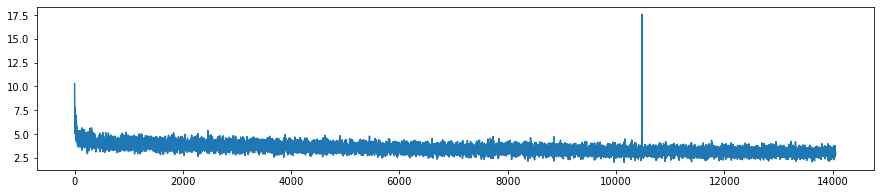

ae_acc_0


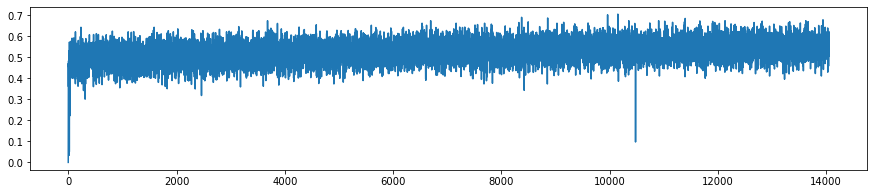

atr_adv_cls_0


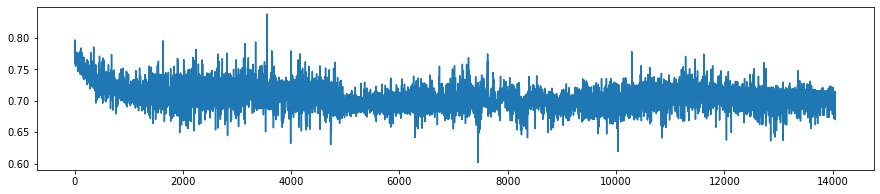

atr_adv_enc_0


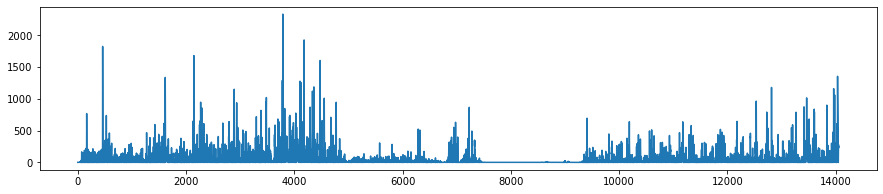

adv_cri_0


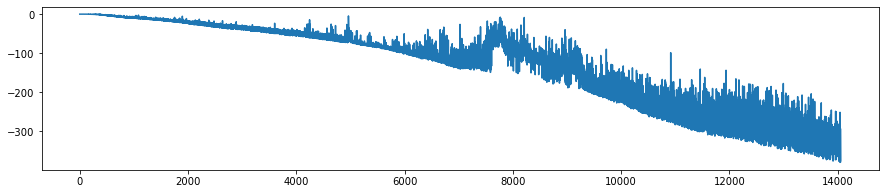

adv_gen_0


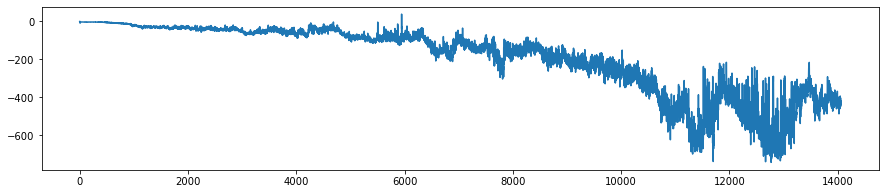

adv_enc_0


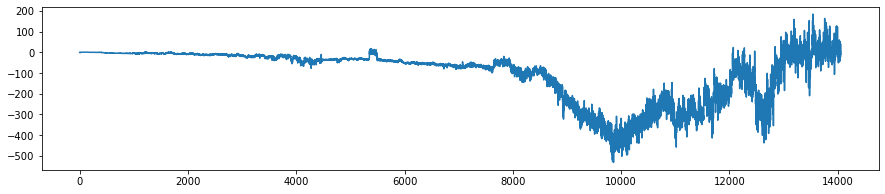

mse_loss_0


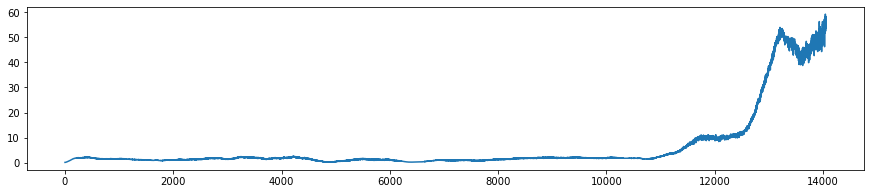

recons_1


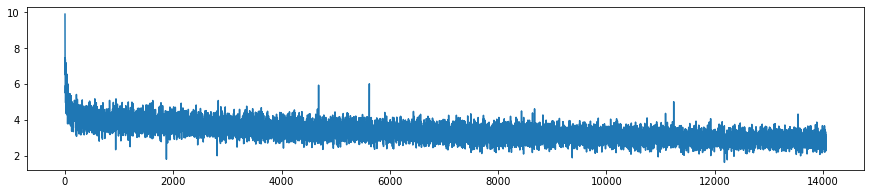

ae_acc_1


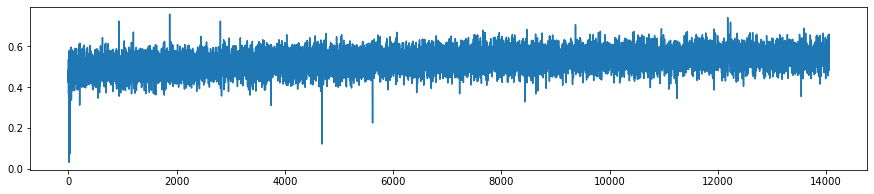

atr_adv_cls_1


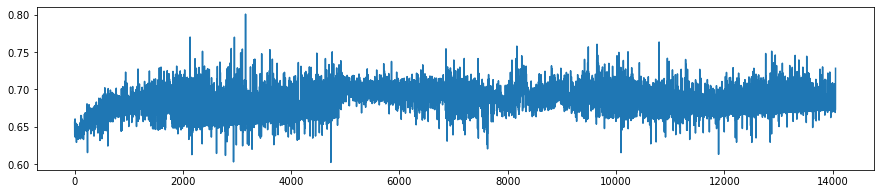

atr_adv_enc_1


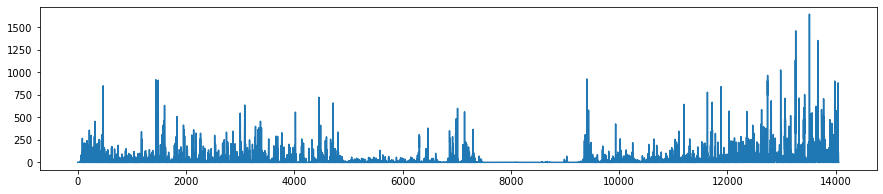

adv_cri_1


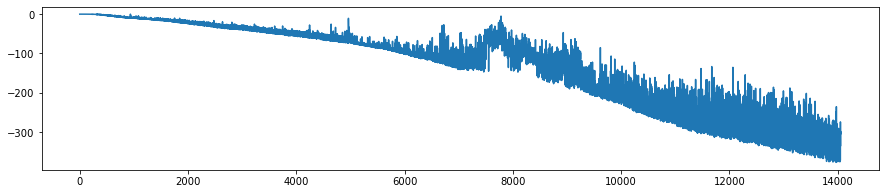

adv_gen_1


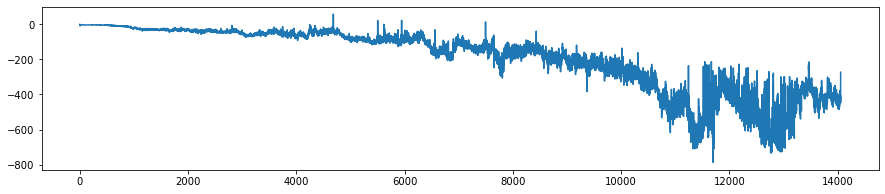

adv_enc_1


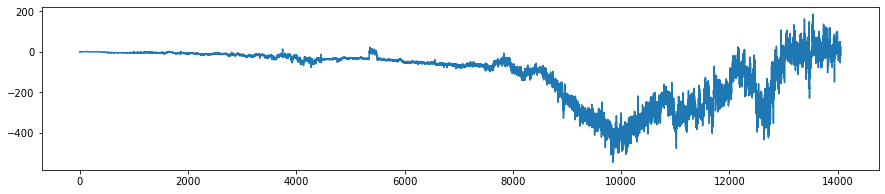

mse_loss_1


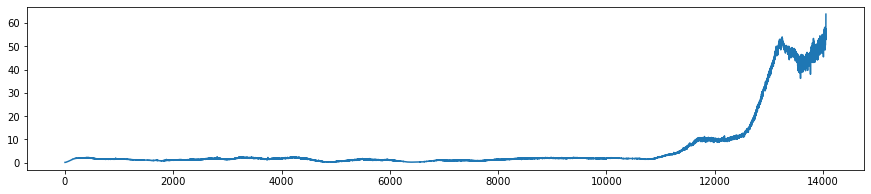

In [8]:
### Train logs
for key in list(train_log.keys()):
    print(key)
    loss_plot(train_log[key])

recons_0


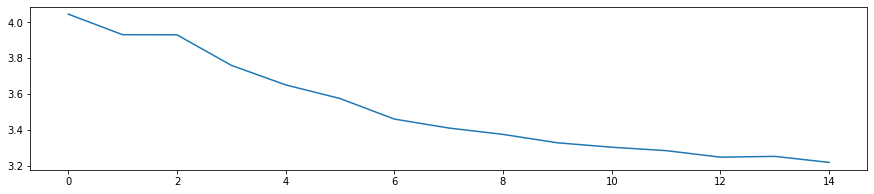

recons_1


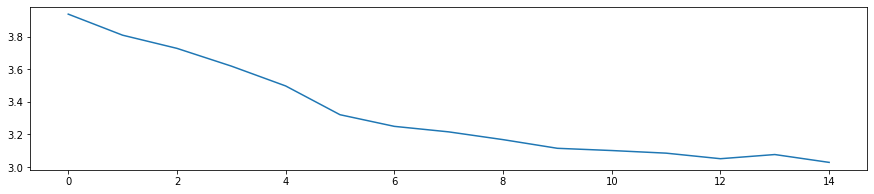

cls_acc


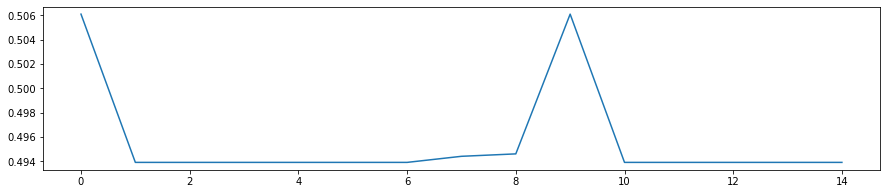

In [9]:
### Test logs
for key in list(test_log.keys()):
    print(key)
    loss_plot(test_log[key])

# Generate random sentences

### Load the models

In [145]:
### 8_000 ~ 10_000 사이가 적당한 듯
encoder.load_state_dict(torch.load("./models/encoder_9.pt"))
dual_decoder.load_state_dict(torch.load("./models/dual_decoder_9.pt"))
generator.load_state_dict(torch.load("./models/generator_9.pt"))

<All keys matched successfully>

### Generation

In [146]:
def generate_from_CLS(batch_size, hidden, which_decoder):
    encoder.eval(); dual_decoder.eval();
    with torch.no_grad():
        ## The fisrt tokens
        tokens = torch.full([batch_size, 1], CLS).to(device) # [batch, 1]
        ## Decoding
        for _ in range(SEQ_LEN - 1):
            one_hot = dual_decoder(tokens, which_decoder=0, hidden_from_encoder=hidden)
            last_one_hot = one_hot[:, -1, :]
            token_id_pred = torch.argmax(last_one_hot, dim=1).unsqueeze(1)
            tokens = torch.concat([tokens, token_id_pred], dim=1)
        
    return tokens

In [147]:
batch_size = 4
which_decoder = 1
generator.eval()

fake_hidden = generator._generate_z_hat(batch_size=batch_size)
dt = generate_from_CLS(batch_size, fake_hidden, which_decoder)
for i in range(batch_size):
    tokens = [t for t in tokenizer.convert_ids_to_tokens(dt[i]) if t!="[PAD]"]
    print(tokens)

['[CLS]', '1', '.', '44', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


# Sentiment flipping

In [148]:
flip_test_dl_0 = DataLoader(test_ds_0, batch_size=BATCH_SIZE, shuffle=0)
flip_test_dl_1 = DataLoader(test_ds_1, batch_size=BATCH_SIZE, shuffle=1)

In [149]:
def sentimnet_flipping(label, how_many):
    print(f"""{('NEGATIVE' if label==0 else 'POSITIVE')} --> {(('POSITIVE' if label==0 else 'NEGATIVE'))}""")
    ## Eval mode
    encoder.eval(); dual_decoder.eval();
    with torch.no_grad():
        ## Get a batch from the test set.
        dataloader = globals()[f"flip_test_dl_{label}"]
        X_test, y_test = next(iter(dataloader))
        X_test = X_test[:how_many, :].to(device)
        y_test = y_test[:how_many, :].to(device)
        
        print("\nORIGINAL TOKENS")
        for i in range(how_many):
            tokens = [t for t in tokenizer.convert_ids_to_tokens(X_test[i]) if t!="[PAD]"]
            print(tokens)
            
        ## Encoding
        hidden = encoder(X_test, noise=False)
        ## Decoding
        decoded_tokens = generate_from_CLS(how_many, hidden=hidden, which_decoder=label)
        ## Sentiment flipping
        flipped_tokens = generate_from_CLS(how_many, hidden=hidden, which_decoder=(1 - label))
        
        print("\nRECONSTRUCTIONS")
        for i in range(how_many):
            results = [t for t in tokenizer.convert_ids_to_tokens(decoded_tokens[i]) if t!="[PAD]"]
            print(results)

        print("\nSENTIMENT FLIPPING")
        for i in range(how_many):
            results = [t for t in tokenizer.convert_ids_to_tokens(flipped_tokens[i]) if t!="[PAD]"]
            print(results)

In [158]:
sentimnet_flipping(label=1, how_many=4)

POSITIVE --> NEGATIVE

ORIGINAL TOKENS
['[CLS]', '여', '##주인', '##공', '##이', '이쁘', '##다', '볼만', '##하다', '꼭', '##보기', '##를', '[SEP]']
['[CLS]', '재밌', '##던데', '[SEP]']
['[CLS]', '호', '##빠', '##하는', '친구', '##생각', '##나', '##넹', '.', '.', '.', '힘들', '##겠', '##당', '.', '.', '.', 'ㅋㅋ', '[SEP]']
['[CLS]', '어릴', '##적', '##에', '봤', '##었는데', '꽤', '재미', '##있게', '봤', '##었네요', '.', '[SEP]']

RECONSTRUCTIONS
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']

SENTIMENT FLIPPING
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
['[CLS]', '1', '##점도', '아깝다', '[SEP]']
